**CS109A Final Project**<br/>
**Group 12**<br/>
**Trevor Noon Regression Work Page**<br/>

Import libraries:

In [21]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import plotly
plotly.tools.set_credentials_file(username='cohenk2', api_key='dF6eJ0G0zN5JH3ifD1sH')
import plotly.plotly as py
import plotly.figure_factory as ff
import scipy.stats as stats
import pylab 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set(color_codes=True)
sns.set(style="whitegrid")
%matplotlib inline

## Our Modeling Journey

Our journey in model creation had a variety of different phases as we iterated through the process running into roadblocks, circled back to try a different method or approach, and then repeated. Looking at an overview of what that actually meant for us we can briefly trace the outline of our steps and then walk through it.

1. Initially, we ran various regressions (linear and regularization-based) on approximately 70 predictor variables. Despite multiple efforts we could not find any model that performed well.

2. Adjusting for this, we went back to our data and bolstered it with additional indicators, interaction terms, and unique predictors we intuitively thought were useful. Running the same models on this data, we still had poor performance (even on our best cross validated Ridge Regression model).

3. Moving away from regression, we decided to switch our focus to classification instead. We defined a success as being known as a 'popular' playlist above our follower threshold and undertook numerous classification models. Ultimately, a Decision Tree model proved to be the best model for us throughout the entire journey. 

4. Now that we are able to tell whether or not a playlist is successful, we tried to create a regression model that would predict just how successful it would be. This intuition made sense because there were so many garbage playlists (eg. Learn to Speak Swedish, etc.). Thinking our data was still being negatively effected by the skew of playlist followers, we decided to only look at the popular playlists that we ultimately are seeking to generate. Using our new bolstered dataset on this subset, we saw mildly improved performance, but nothing substantial enough to gain incredible insights. 

Thus, at the end, we are able to predict, with some accuracy, whether or not a playlist will be successful or not. Once we predict whether or not it is successful, we can predict how successful it will be (using a relatively unreliable model).

## Model A: Regressing on the Full Dataset

One of the goals of our project was to be able to predict the number of followers of a playlist, given a number of songs and their artists. Our first, and simplest predictive model was the Ordinary Least-Squares Multiple Linear Regression Model, which aims to minimize the error produced by a linear function of our predictors. In this case, error is defined by taking the mean of our squared residuals (the actual number of followers - our predicted number). This linear function of our predictors provides us with a simple equation relating our predictors, such as average artist popularity or song duration, to our response variable, the logged number of followers of a playlist.

The benefit of this simple model is that it’s highly interpretable and easy to understand. However, due to the simplicity of the model, there are definitely assumptions that we must account for.
1. Normality: our residuals should be normally distributed. We check this below using a residual vs. fitted plot.
2. Equal Variance: We should have the same variance with each observation; we can also check this below with the residual plot below.
3. Linearity: Our predictors should have a linear relationship with our response; we can observe whether this is violated by checking to see if there are any patterns or any curvature in the residual plot below. Additionally, we saw some of these relationships directly in our EDA. 
4. Independence: Our predictors should be linearly independent, if not, there is multicollinearity in our model. We can account for this by removing predictors that are highly correlated.

In [22]:
df = pd.read_csv("train_data.csv")
del df['Unnamed: 0']

# Cross Validation Setup
x_train = df.iloc[:,3:503]
y_train = df['followers']
kf = KFold(n_splits=5)
kf.get_n_splits(x_train)
x_train = x_train.replace([np.inf, -np.inf], 0)
x_train = x_train.fillna(0)
y_train = y_train.replace([np.inf, -np.inf], 0)
y_train = y_train.fillna(0)

df.head()

,playlist,name,followers,num_songs,av_song_pop,pct_explicit,avg_dur,av_artist_followers,pop_pct,rap_pct,...,Post Malone*rap_pct,Post Malone*rock_pct,Post Malone*hip_hop_pct,Post Malone*country_pct,Post Malone*metal_pct,Post Malone*indie_folk_pct,Post Malone*rnb_pct,Post Malone*edm_pct,Post Malone*classical_pct,Post Malone*jazz_pct
0,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,16.712741,-0.095155,2.767125,1.329673,-0.352106,1.131506,0.999423,0.889318,...,0.36,0.00,0.12,0.0,0.0,0.08,0.02,0.22,0.0,0.0
1,37i9dQZF1DX3LyU0mhfqgP,Out Now,12.993814,0.104091,2.094954,0.493535,-0.356516,0.654250,0.596919,-0.250860,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
2,37i9dQZF1DX7Axsg3uaDZb,Top Tracks of 2016 - USA,8.558527,1.897301,1.931070,1.911124,-0.291292,1.401707,1.386834,1.246525,...,0.45,0.07,0.25,0.0,0.0,0.08,0.06,0.19,0.0,0.0
3,37i9dQZF1DWWoCDtOBjhpE,Top Female Artists of 2016 - USA,0.000000,-1.290629,1.708333,0.589643,-0.230856,1.427494,1.552867,0.055833,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
4,7qLIVhpCFAiX1Teqf3L6Y4,Happy Birthday Cheryl!,5.332719,-0.892138,-0.386537,-0.467542,-0.284179,0.829675,1.091664,0.254282,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0


We initially ran was an ordinary least squares regression using all predictors. This resulted in severe overfitting because of the abundance of predictors we had when compared to the actual number of playlists that we were trying to predict from. We know that we're overfitting the data because all of our training set $R^2$ values are incredibly high around 0.9, but the test and cross validated $R^2$ values were either 0 or even negative.

In [23]:
# Full Model
full_r2_train = []
for train_index, test_index in kf.split(x_train):
    train_start = train_index[0]
    train_end = train_index[-1]
    test_start = test_index[0]
    test_end = test_index[-1]
    regres = sm.OLS(y_train[train_start:train_end], x_train[train_start:train_end])
    results_k = regres.fit()
    y_hat_k_train = results_k.predict(x_train[test_start:test_end])
    full_r2_train.append(r2_score(y_train[test_start:test_end],y_hat_k_train))
    
print("Full Model CV R^2: ", np.mean(full_r2_train))

regress = sm.OLS(y_train, x_train)
results_full = regress.fit()
# results_full.summary()

Full Model CV R^2:  -6.84646555406


Despite the overfitting problem, we want to look and see if linear regression is even a good fit at all and whether or not we violate any of the assumptions necessary for a model like this to work. Generally, for linear regression to be valid we want data that is normally distributed. As discussed in the EDA section, playlist followers are heavily right skewed so we performed a log transformation. Even with this transformation, however, the data was still rather far from normal which caused some reverberating problems throughout our models. Additionally, there were no directly apparent linear relationships present between our predictors and response variables nor any visible helpful transformations.

Looking at the models themselves, we can see if their inherent assumptions held. The first assumption for our model to be valid is that our residuals are normally distributed with mean 0 and a constant variance. Looking at the distribution of our residuals we can see that the mean is indeed 0, however they don't look like they have constant variance as we have far more positive residuals than negatives. Indeed, looking at our fitted values for log followers when compared to the true number of followers, as well as a quantile-quantile plot we tend to generally predict far too many playlists to be located around the mean of the true dataset.

count    1.106000e+03
mean    -2.442852e-13
std      2.486787e+00
min     -6.941227e+00
25%     -1.500287e+00
50%     -1.330935e-12
75%      7.345288e-01
max      1.117090e+01
dtype: float64

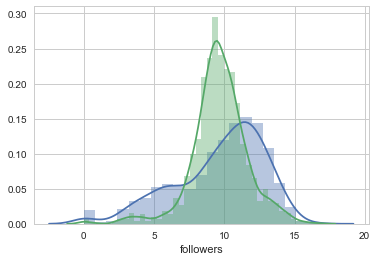

In [24]:
yhat_full = results_full.predict(x_train)
sns.distplot(y_train)
sns.distplot(yhat_full)
resid = yhat_full - y_train
resid.describe()

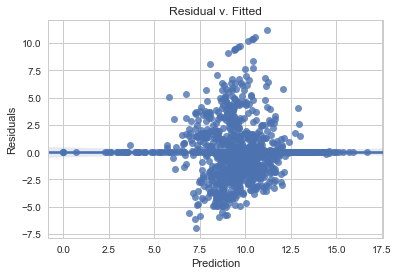

In [25]:
plt.figure()
sns.regplot(yhat_full,resid)
plt.xlabel('Prediction')
plt.ylabel('Residuals')
plt.title('Residual v. Fitted')

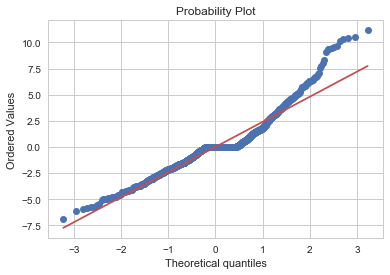

In [26]:
stats.probplot(resid, dist="norm", plot=pylab)
pylab.show()

Despite the fact that we violated some key assumptions, we looked further into linear regression to try and remedy the overfitting problem. Utilizing backwards stepwise regression and eliminating insignificant predictors, we hoped to address the problem. With that said, however, we were unsuccessful as we still experienced overfitting. This may seem strange since now there are only 14 predictors, but in examining the predictors the overfitting becomes clear. It makes absolutely no sense to have a significant variable of the interaction between Dua Lipa's presence in a playlist and the amount of country that it has to effect success by an enormous factor of $e^{70}$.

In [27]:
# OLS Backwards Stepwise
# Regress loop
complete = False
all_vars = list(x_train.columns)
while(complete == False):
    # Regression
    x_this = x_train[all_vars]
    regr = sm.OLS(y_train, x_this)
    results_this = regr.fit()
    # Pull max p-value
    pvals = results_this.pvalues
    for variable in range(len(pvals)):
        pvals[variable] = float(pvals[variable])
    variable = pvals.idxmax(axis = 0)
    max_p = max(pvals.values)
    # Remove that variable if p > .05
    if max_p > 0.05:
        all_vars.remove(variable)
    else:
        complete = True

regress_bw = sm.OLS(y_train, x_train[all_vars])
results_bw = regress_bw.fit()
print(results_bw.summary())

bw1_vars = all_vars
x_bw1 = x_train[bw1_vars] 

# Backwards 
bw1_r2_train = []
for train_index, test_index in kf.split(x_bw1):
    train_start = train_index[0]
    train_end = train_index[-1]
    test_start = test_index[0]
    test_end = test_index[-1]
    regres = sm.OLS(y_train[train_start:train_end], x_bw1[train_start:train_end])
    results_k = regres.fit()
    y_hat_bw1_train = results_k.predict(x_bw1[test_start:test_end])
    bw1_r2_train.append(r2_score(y_train[test_start:test_end],y_hat_bw1_train))
    
print("Backwards Stepwise CV Train R^2: ", np.mean(bw1_r2_train))

                            OLS Regression Results                            
Dep. Variable:              followers   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     9.931
Date:                Thu, 07 Dec 2017   Prob (F-statistic):           2.32e-35
Time:                        15:40:51   Log-Likelihood:                -2738.4
No. Observations:                1106   AIC:                             5531.
Df Residuals:                    1079   BIC:                             5666.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
num_songs         

Moving away from pure linear regression, we looked for better success with regularization methods - specifically Lasso and Ridge regression. The main difference between the OLS regression and these regularization methods are that they both introduce a penalty factor. The methods still inherently minimize a loss function (to minimize error), but the penalty factors serve to account for extreme values in parameters. Lasso's penalty form relies on the absolute value of the coefficients while ridge uses the square of the coefficients (notice how both must be positive to increase the loss function and actually serve as a penalty). 


Our hope was that their penalty factors would address the aforementioned problem present within backwards stepwise overfitting whilst still retaining some simplicity of less predictors. Ultimately, these regularization methods did address the overfitting, but had little performance improvement as a result. 

In [28]:
# Lasso
lasso_reg = LassoCV()
lasso_reg.fit(x_train, y_train)
yhat_train_lasso = lasso_reg.predict(x_train)
print("Lasso Train R^2: " ,r2_score(y_train,yhat_train_lasso))

Lasso Train R^2:  0.147704204575


In [29]:
# Ridge
ridge_reg = RidgeCV()
ridge_reg.fit(x_train, y_train)
yhat_train_ridge = ridge_reg.predict(x_train)
print("Ridge Train R^2: " ,r2_score(y_train,yhat_train_ridge))

Ridge Train R^2:  0.197137758465


In [30]:
data_matrix = [['Model Type', 'Train R^2 Performance', 'Overfitting?'],
               ['Full Linear', 'Negative', 'NA'],
               ['Backwards Stepwise', 'Negative', 'NA'],
               ['LassoCV', 0.148, 'Unlikely'],
               ['RidgeCV', 0.197, 'Unlikely']]

table = ff.create_table(data_matrix)
py.iplot(table, filename='simple_table')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~cohenk2/0 or inside your plot.ly account where it is named 'simple_table'


## Model C: Regression: How Popular Is Popular?

Since we are now able to predict whether or not a playlist will be popular, we attempt to create a regression model to figure out how successful a playlist that is classified as successful will be. 

Here, we try to create a regression model, trained on the top quartile of playlists, since these are those that we consider "successful." Given that a playlist is successful, our model will tell us how successful it is. Circling back on another attempt to try regression, we decided to refocus and only look at playlists that were deemed popular (in the top quartile of followers). Looking only at this subset then, we recentered our dataset and tried the same regularization methods.

** As a note: ** Here, we skip explaining some of the assumptions underlying the models because we already explained many of the assumptions when we were going through Model A. We follow a similar process below.

In [75]:
pop = df.loc[df['followers'] >= np.log(163000)]
pop['followers'] = pop['followers'] - np.log(163000)
pop.head()

,playlist,name,followers,num_songs,av_song_pop,pct_explicit,avg_dur,av_artist_followers,pop_pct,rap_pct,...,Post Malone*rap_pct,Post Malone*rock_pct,Post Malone*hip_hop_pct,Post Malone*country_pct,Post Malone*metal_pct,Post Malone*indie_folk_pct,Post Malone*rnb_pct,Post Malone*edm_pct,Post Malone*classical_pct,Post Malone*jazz_pct
0,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,4.711236,-0.095155,2.767125,1.329673,-0.352106,1.131506,0.999423,0.889318,...,0.36,0.0,0.12,0.0,0.0,0.08,0.02,0.22,0.0,0.0
1,37i9dQZF1DX3LyU0mhfqgP,Out Now,0.992308,0.104091,2.094954,0.493535,-0.356516,0.654250,0.596919,-0.250860,...,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
5,37i9dQZF1DWU13kKnk03AP,Daily Lift,1.791751,-0.055306,2.280426,0.465268,-0.406380,0.795643,1.118793,0.083071,...,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
7,37i9dQZF1DX1dvMSwf27JO,Study Break,0.891364,0.183789,1.435792,0.367078,-0.352594,0.882897,1.164485,-0.191357,...,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0
12,37i9dQZF1DWUACcBjzMiIY,Mellow Nights,1.506135,0.183789,1.212179,-0.374806,-0.186847,1.255306,1.504319,-0.330619,...,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0


This is a substantial change by which we have essentially eliminated about 75% of our data. With this big change, we did see a slight uptick in performance, but unfortunately nothing substantial. We start first with a Full Linear Model.

### Full Linear Regression Model

In [133]:
# Only looking at popular 
np.random.seed(9001)
msk = np.random.rand(len(pop)) < 0.75
data_train = pop[msk]
data_validate = pop[~msk]

x_train = data_train.iloc[:,3:503]
x_test = data_validate.iloc[:,3:503]
y_train = np.log(data_train['followers'])
y_test = np.log(data_validate['followers'])

x_train = x_train.replace([np.inf, -np.inf, np.nan], 0)
x_train = x_train.fillna(0)
x_test = x_test.replace([np.inf, -np.inf], 0)
x_test = x_test.fillna(0)
y_test = y_test.replace([np.inf, -np.inf], 0)
y_test = y_test.fillna(0)

pop_regress = sm.OLS(y_train, x_train)
pop_results = pop_regress.fit()

Since there are far too many predictors in the full linear regression model, we will suppress the output. Instead, we try a Backward Stepwise regression to eliminate some of the predictors and prevent overfitting.

### Backward Stepise for Linear Regression

In [83]:
# OLS Backwards Stepwise
# Regress loop
complete = False
all_vars = list(x_train.columns)
while(complete == False):
    # Regression
    x_this = x_train[all_vars]
    regr = sm.OLS(y_train, x_this)
    results_this = regr.fit()
    # Pull max p-value
    pvals = results_this.pvalues
    for variable in range(len(pvals)):
        pvals[variable] = float(pvals[variable])
    variable = pvals.idxmax(axis = 0)
    max_p = max(pvals.values)
    # Remove that variable if p > .05
    if max_p > 0.05:
        all_vars.remove(variable)
    else:
        complete = True

regress_bw = sm.OLS(y_train, x_train[all_vars])
results_bw = regress_bw.fit()
print(results_bw.summary())

bw1_vars = all_vars
x_bw1 = x_train[bw1_vars] 

# Backwards 
bw1_r2_train = []
for train_index, test_index in kf.split(x_bw1):
    train_start = train_index[0]
    train_end = train_index[-1]
    test_start = test_index[0]
    test_end = test_index[-1]
    regres = sm.OLS(y_train[train_start:train_end], x_bw1[train_start:train_end])
    results_k = regres.fit()
    y_hat_bw1_train = results_k.predict(x_bw1[test_start:test_end])
    bw1_r2_train.append(r2_score(y_train[test_start:test_end],y_hat_bw1_train))
    
print("Backwards Stepwise CV Train R^2: ", np.mean(bw1_r2_train))

                            OLS Regression Results                            
Dep. Variable:              followers   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     12.51
Date:                Thu, 07 Dec 2017   Prob (F-statistic):           6.40e-12
Time:                        16:26:12   Log-Likelihood:                -306.91
No. Observations:                 202   AIC:                             625.8
Df Residuals:                     196   BIC:                             645.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
av_song_pop             

In [134]:
y_hat_test_bw = results_bw.predict(x_test[bw1_vars])
print("Backwards Stepwise Test R^2: ", r2_score(y_test, y_hat_test_bw))

Backwards Stepwise Test R^2:  -0.0472257109862


Since we see a particularly bad test R^2 score, we go ahead and try other regression methods that we have learned, such as Ridge and Lasso Regularizations. We begin with those below.

### Ridge Regression

In [115]:
ridge_reg = RidgeCV()
ridge_reg.fit(x_train, y_train)
yhat_train_ridge = ridge_reg.predict(x_train)
yhat_test_ridge = ridge_reg.predict(x_test)
print("Ridge Train R^2: " ,r2_score(y_train,yhat_train_ridge))
print("Ridge Test R^2: " ,r2_score(y_test,yhat_test_ridge))

Ridge Train R^2:  0.30895531482
Ridge Test R^2:  -0.0257503367149


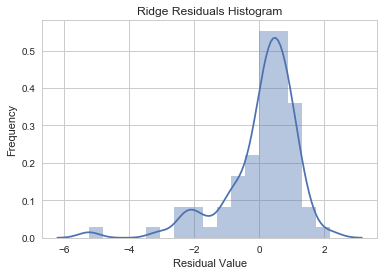

In [131]:
sns.distplot(resids_ridge)
plt.title('Ridge Residuals Histogram')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()


Above, we see the scatterplot and histograms of the residuals, which seems relatively left skewed, which is an issue. Let's try Lasso Regression, now.

### Lasso Regression

In [118]:
lasso_reg = LassoCV()
lasso_reg.fit(x_train, y_train)
yhat_train_lasso = lasso_reg.predict(x_train)
yhat_test_lasso = lasso_reg.predict(x_test)
print("Lasso Train R^2: " ,r2_score(y_train,yhat_train_lasso))
print("Lasso Test R^2: " ,r2_score(y_test,yhat_test_lasso))

Lasso Train R^2:  0.229580517999
Lasso Test R^2:  -0.0155792592175


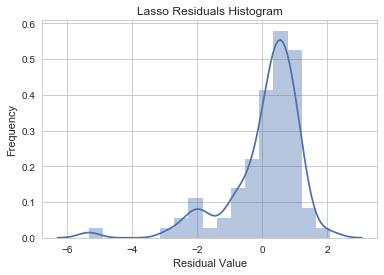

In [132]:
sns.distplot(resids_lasso)
plt.title('Lasso Residuals Histogram')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

We can take a higher level look at all of our models and compare their potentials, but really since all of these models have negative test $R^2$ values there really doesn't seem to be much here and we need to look elsewhere moving forward.

In [125]:
data_matrix = [['Model Type', 'Train R^2 Performance', 'Test R^2 Performance','Overfitting?'],
               ['Full Model', 0.518 , 'Negative', 'Definitely'],
               ['Backwards Stepwise',0.13 , 'Negative' , 'Definitely'],
               ['RidgeCV', 0.31, 'Negative', 'Definitely'],
               ['LassoCV', 0.23, 'Negative', 'Definitely']]

table = ff.create_table(data_matrix)
py.iplot(table, filename='simple_table')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~cohenk2/0 or inside your plot.ly account where it is named 'simple_table'


Of the above four models, we would choose the Cross Validated Ridge Model. We say this for a couple of reasons.
1. First, the Ridge Model uses regularization methods to decrease the bias caused be certain variables. This is particularly important in a case like this when we have so many predictors and comparatively fewer variables.
2. Second, the Ridge Model is easily interpretable-- we have listed the significant coefficients above (with regularization penalty). This is great news in terms of whether or not Spotify will actually be able to make use of our findings. 
3. The histogram of the residuals is still left skewed, but that is true of the residuals for Lasso as well, so this point is essentially a wash. 
4. The Ridge Train R^2 is relatively high (though we acknowledge the high likelihood of overfitting).

In [124]:
coef_vals = ridge_reg.coef_
factors = pd.DataFrame(coef_vals, columns = ['Coefficient'])
factors['Variable'] = x_train.columns
factors = factors.sort_values('Coefficient')
factors[abs(factors['Coefficient']) > 0.15]

,Coefficient,Variable
27,-0.392750,this_or_not
67,-0.362134,Drake
14,-0.311361,classical_pct
28,-0.297277,number_or_not
49,-0.285923,The Weeknd
7,-0.175691,rock_pct
20,-0.175381,top_song_pop
18,-0.152791,top_artist_pop
45,0.151759,Rihanna
60,0.152470,J Balvin


** Discussion of Significant Variables **

Here we attempt to discuss the most significant variables. The variable that seems to contribute most positively to increased success in a playlist is increasing the average song popularity, which intuitively makes sense since these songs tend to draw people in. Additioanlly, the "top or not" variable, which accounts for words like "Hot", "Top", or "viral" in the playlist name, increases success-- this may be because of confounding factors like Spotify being more likely to increase the visibility of these playlists. The average popularity of the top 3 artists, the range of artist popularity, and the presence of Rihanna or JBalvin in the playlist increases the success of the playlist. 

Conversely, the higher the popularity of the top artist and song, the lower the success of the playlist (which is intuitively surprising!-- of course, this is a good time to mention the possibility of errors like multicollinearity, etc.). The percentage of rock and classical songs, the presence of The Weeknd and Drake, the presence of a number or the words "This Is:" in the playlist title reduces the success of the playlist.

Here we see that while we were able to increase the Training R^2 of our dataset, the Test R^2 of the data was still particularly bad-- in fact, all Test R^2s were negative. This intuitively makes sense because with so many predictors and so few data (since we dropped so many of our observations), we are very likely to overfit. Despite using regularization methods like Lasso and Ridge to reduce the effectiveness of unnecessary variables, we still find that the models are quite bad. 

At this point, it feels as though we have tried everything and conclude that no regression model can effectively predict the number of followers our playlist will have. Though regression methods appear to be pretty useless here, we do note the everall effectiveness of the classification model in determining whether or not a playlist will perform in the top 25% of playlists.